<a target="_blank" href="https://colab.research.google.com/github/gena/next25-weather/notebooks/weathernext-bigquery-simple.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Exploring Global Weather Forecasts with BigQuery and WeatherNext

**Welcome!** This notebook introduces a weather forecast dataset available in BigQuery, generated by Google DeepMind's WeatherNext (formerly GraphCast) model. Through a series of sample queries, we'll demonstrate how to access, analyze, and visualize this data to gain insights into global weather patterns, trends, and potential impacts.

**Dataset Overview**

This dataset offers weather forecasts produced by WeatherNext, a state-of-the-art machine learning model developed by Google DeepMind. It provides predictions for various weather variables, including temperature, precipitation, wind speed, and more, at a global scale and with a high degree of accuracy. The dataset is partitioned by day on the `init_time` column, similar to the structure used by NOAA in their weather data tables.

**Notebook Purpose**

This notebook aims to:

* Familiarize users with the structure and content of the WeatherNext weather forecast dataset in BigQuery.
* Demonstrate how to query and analyze this data using BigQuery's powerful tools and functions.
* Showcase the potential applications of this data for various weather-related tasks, such as forecasting, climate analysis, and risk assessment.

**Copyright Information**

* **Dataset:**  The weather forecast data is generated by Google DeepMind's WeatherNext model.
* **Notebook:** Copyright 2024 Google LLC. This notebook is licensed under the Apache License, Version 2.0.

[BigQuery Client Library Documentation](https://cloud.google.com/python/docs/reference/bigquery/latest)

## Import Python Libraries & Some Other Setup

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np

import warnings
# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

## Set Google Cloud/BigQuery Project ID

In [6]:
project_id = 'dgena-ee-training' #@param{type:"string"}

# Weather Forecast Dataset Schema

This describes the schema for a weather forecast dataset.

## Top-level fields

<div align="left">

| Field Name | Type | Mode | Description |
|---|---|---|---|
| `init_time` | TIMESTAMP | NULLABLE | The initialization time of the forecast. |
| `geography` | GEOGRAPHY | NULLABLE | The geographic point location for this forecast. |
| `geography_polygon` | GEOGRAPHY | NULLABLE | The geographic polygon associated with the forecast. |
| `forecast` | RECORD (REPEATED) | NULLABLE | Contains detailed forecast information for different time horizons. |

</div>

## Fields within the `forecast` record

<div align="left">

| Field Name | Type | Mode | Description |
|---|---|---|---|
| `time` | TIMESTAMP | NULLABLE | The specific time the forecast is valid for. |
| `hours` | INTEGER | NULLABLE | The number of hours from the `init_time`. |
| `total_precipitation_6hr` | FLOAT | NULLABLE | Total precipitation over a 6-hour period (in mm). |
| `10m_u_component_of_wind` | FLOAT | NULLABLE | The u-component of wind at 10 meters above the surface (in m/s). |
| `10m_v_component_of_wind` | FLOAT | NULLABLE | The v-component of wind at 10 meters above the surface (in m/s). |
| `2m_temperature` | FLOAT | NULLABLE | Temperature at 2 meters above the surface (in K). |
| `mean_sea_level_pressure` | FLOAT | NULLABLE | Mean sea level pressure (in Pa). |

</div>

### Forecast variables at various pressure levels

The `forecast` record also includes the following variables at various pressure levels (50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000 hPa):

* **`*_geopotential` (FLOAT):** Geopotential height (in m).
* **`*_specific_humidity` (FLOAT):** Specific humidity (in kg/kg).
* **`*_temperature` (FLOAT):** Temperature (in K).
* **`*_u_component_of_wind` (FLOAT):**  The u-component of wind (in m/s).
* **`*_v_component_of_wind` (FLOAT):** The v-component of wind (in m/s).
* **`*_vertical_velocity` (FLOAT):** Vertical velocity (in m/s).

## Key points about the schema

* **`forecast` is REPEATED:** The `forecast` field is a repeated record, meaning it contains an array of forecast values for different time horizons within a single row.

* **Column names starting with numbers:** Some column names start with numbers (e.g., `2m_temperature`) and need to be enclosed in backticks (`) when used in queries.

# Example Queries

**Using the `%%bigquery` magic command**

In this notebook, we use the `%%bigquery` magic command to execute queries against the weather forecast dataset in BigQuery. This command allows you to write and run SQL queries directly within a Jupyter Notebooks cell.

Here's the basic syntax:

*  `%%bigquery`: This is the magic command that tells Colab to execute the cell contents as a BigQuery query.
*  `[variable_name]`: (Optional) This is the name of the variable where the query results will be stored as a pandas DataFrame. If you omit this, the results will be displayed directly in the cell output.
*  `--project [project_id]`: This specifies the Google Cloud project ID where the query should be executed.
*  `[Your SQL query]`: This is the actual SQL query you want to run.

**Example:**

```sql
%%bigquery dataset --project your-project-id
SELECT ...
FROM ...
WHERE ...

```

## Exploring Temperature Forecasts for New York City - 5 Day

This query retrieves the 2-meter temperature forecasts for New York, NY, demonstrating how to access and analyze the core weather data in the table.


In [31]:
%%bigquery ny_temps --project {project_id}
SELECT
    t2.time AS time,
    t2.`2m_temperature` as `2m_temperature`
    # AVG(t2.`2m_temperature`) as `2m_temperature`
  FROM
    `gcp-public-data-weathernext.WeatherNext.59572747_4_0` AS t1, t1.forecast AS t2
  WHERE ST_INTERSECTS(t1.geography_polygon, ST_GEOGFROMTEXT('POLYGON((-70.66 40.64, -73.85 40.64, -73.85 40.89, -70.66 40.89, -70.66 40.64))'))  # New York City
   AND t1.init_time = TIMESTAMP('2024-10-17 00:00:00 UTC')
  # GROUP BY t2.time
  ORDER BY t2.time


Query is running:   0%|          |

Downloading:   0%|          |

In [32]:
ny_temps

,time,2m_temperature
0,2024-10-17 06:00:00+00:00,279.774841
1,2024-10-17 06:00:00+00:00,279.538666
2,2024-10-17 06:00:00+00:00,279.855286
3,2024-10-17 06:00:00+00:00,278.873383
4,2024-10-17 06:00:00+00:00,283.650909
...,...,...
1035,2024-10-27 00:00:00+00:00,287.397156
1036,2024-10-27 00:00:00+00:00,287.369720
1037,2024-10-27 00:00:00+00:00,286.897766
1038,2024-10-27 00:00:00+00:00,287.318573


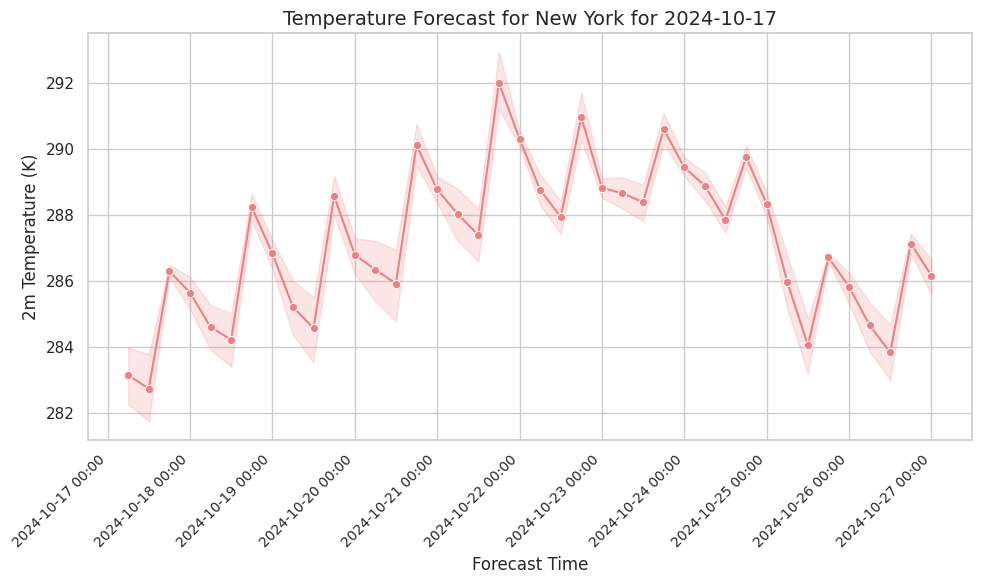

In [34]:
# Extract the date from the first forecast_time
forecast_date = ny_temps['time'].iloc[0].strftime('%Y-%m-%d')

# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))
sns.lineplot(x=mdates.date2num(ny_temps['time'].dt.to_pydatetime()), y=ny_temps['2m_temperature'], marker='o', linestyle='-', color='lightcoral')
plt.xlabel('Forecast Time', fontsize=12)
plt.ylabel('2m Temperature (K)', fontsize=12)
plt.title(f'Temperature Forecast for New York for 2024-10-17', fontsize=14)

# Format the x-axis ticks
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))  # Show date and time
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))  # Show ticks for each day
plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()

### Analyzing Precipitation Forecasts for Chicago - 5 Day

This query retrieves the forecasted 6 hour total precipitation over a 5 days period for Chicago, Illinois, further demonstrating how to access specific weather variables and filter by forecast time.



In [36]:
%%bigquery chicago_precip --project {project_id}
SELECT
    t2.time,  -- Add the forecast time to the SELECT statement
    t2.total_precipitation_6hr
  FROM
    `gcp-public-data-weathernext.WeatherNext.59572747_4_0` AS t1, t1.forecast AS t2
  WHERE ST_CONTAINS(t1.geography_polygon, ST_GEOGPOINT(-87.65, 41.85))
   AND t1.init_time = TIMESTAMP('2024-10-20 00:00:00 UTC')

Query is running:   0%|          |

Downloading:   0%|          |

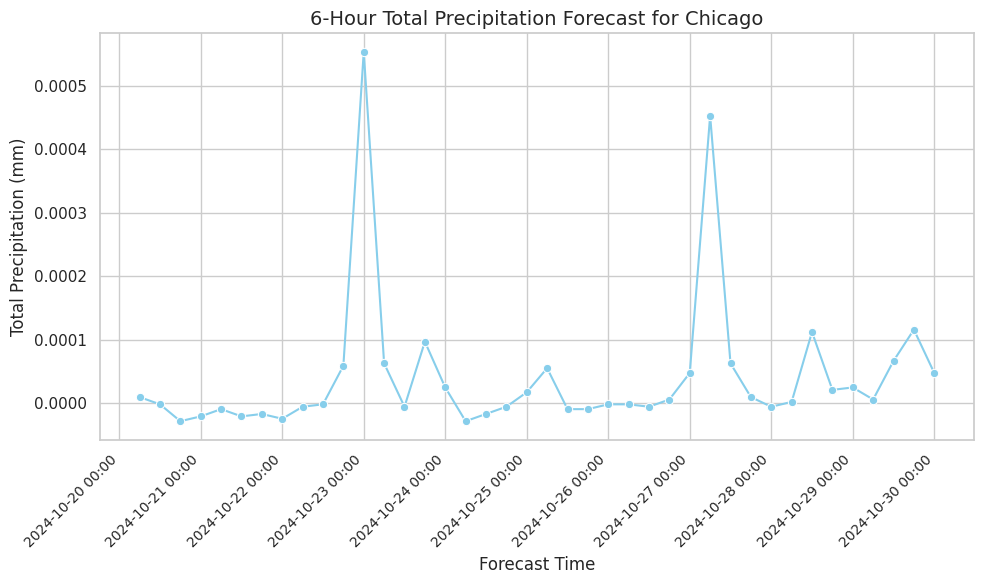

In [37]:
# Set the aesthetic style of the plots
sns.set_theme(style="whitegrid")

# Plot the data
plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
sns.lineplot(x='time', y='total_precipitation_6hr', data=chicago_precip, marker='o', linestyle='-', color='skyblue', errorbar=None)
plt.xlabel('Forecast Time', fontsize=12)
plt.ylabel('Total Precipitation (mm)', fontsize=12)
plt.title('6-Hour Total Precipitation Forecast for Chicago', fontsize=14)

# Format the x-axis ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

plt.xticks(rotation=45, ha='right', fontsize=10)

plt.tight_layout()
plt.show()



```
# This is formatted as code
```

## Average Wind Speed & Temperature for 10 Day period - London

In [43]:
%%bigquery london_wind_temp --project {project_id}
SELECT
    t2.time,
    SQRT(POW(t2.`10m_u_component_of_wind`, 2) + POW(t2.`10m_v_component_of_wind`, 2)) AS wind_speed,
    t2.`2m_temperature` AS temperature
FROM
    `gcp-public-data-weathernext.WeatherNext.59572747_4_0` AS t1, t1.forecast AS t2
WHERE ST_INTERSECTS(t1.geography_polygon, ST_GEOGPOINT(-0.1278, 51.5074))  # London
  AND t1.init_time = TIMESTAMP('2024-10-17 00:00:00 UTC')
ORDER BY t2.time

Query is running:   0%|          |

Downloading:   0%|          |

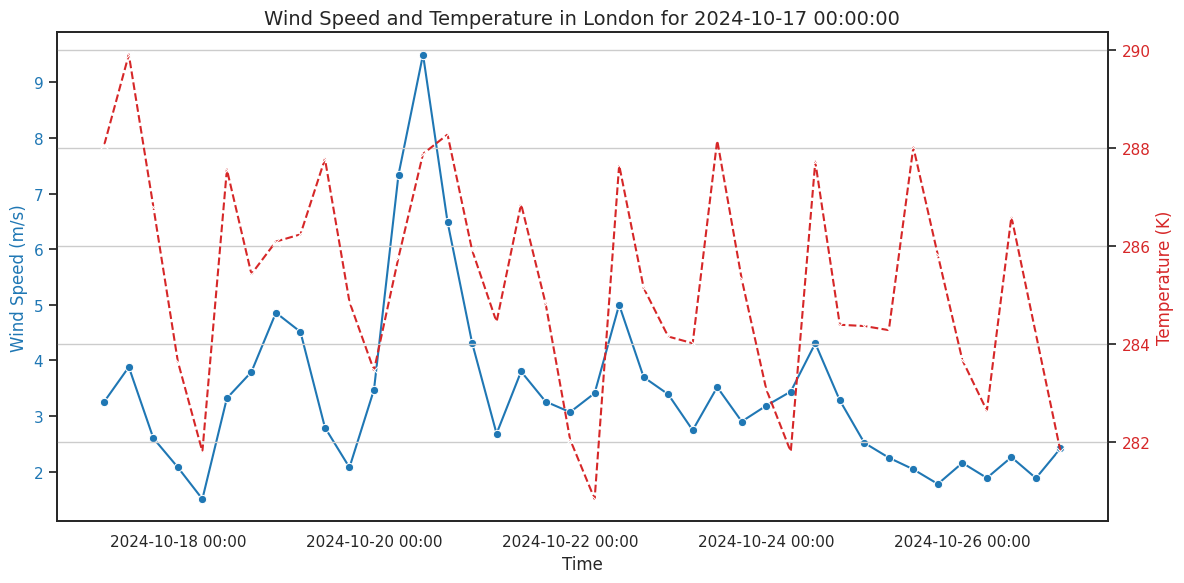

In [50]:
# Set the aesthetic style
sns.set_theme(style="white")

# Plot the data with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Wind speed
color = 'tab:blue'
sns.lineplot(x='time', y='wind_speed', data=london_wind_temp, marker='o', linestyle='-', color=color, ax=ax1)
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Wind Speed (m/s)', color=color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=color)

# Temperature
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
color = 'tab:red'
sns.lineplot(x='time', y='temperature', data=london_wind_temp, marker='x', linestyle='--', color=color, ax=ax2)
ax2.set_ylabel('Temperature (K)', color=color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=color)

# Format the x-axis ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2))

plt.xticks(rotation=45, ha='right', fontsize=10)

# Add gridlines
plt.grid(True)  # Add gridlines to the plot

plt.title('Wind Speed and Temperature in London for 2024-10-17 00:00:00', fontsize=14)
fig.tight_layout()
plt.show()

## Colorado 2m Temperature  - 10/17/2024 00:00 Hours

In [51]:
%%bigquery colorado_2m_temp --project {project_id}
SELECT
  f.`2m_temperature` - 273.15 AS `2m_temperature_celsius`,  -- Subtract 273.15 to convert from Kelvin to Celsius
  ST_X(ST_Centroid(t.geography_polygon)) AS longitude,
  ST_Y(ST_Centroid(t.geography_polygon)) AS latitude
FROM
  `gcp-public-data-weathernext.WeatherNext.59572747_4_0` AS t,
  t.forecast AS f
WHERE ST_CONTAINS(t.geography_polygon, t.geography)
  AND ST_CONTAINS((
    SELECT
      state_geom
    FROM
      `bigquery-public-data`.geo_us_boundaries.states
    WHERE state_name = 'Colorado'
  ), t.geography)
  AND t.init_time = TIMESTAMP('2024-10-14 00:00:00 UTC')
  AND f.time = TIMESTAMP('2024-10-24 00:00:00 UTC');  -- Filter by the specified time

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
colorado_2m_temp

,2m_temperature_celsius,longitude,latitude
0,19.312372,-103.50,36.999997
1,7.526392,-106.25,37.249997
2,11.579370,-106.00,36.999997
3,17.134058,-102.75,39.249993
4,17.785516,-103.00,38.749994
...,...,...,...
460,10.911768,-108.50,40.999988
461,9.528497,-107.50,38.999993
462,17.272913,-102.75,39.499992
463,11.223840,-108.50,37.499996


In [53]:
# convert points to an image
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

x = colorado_2m_temp['longitude']
y = colorado_2m_temp['latitude']
z = colorado_2m_temp['2m_temperature_celsius']

ny = len(np.unique(y)) // 25
nx = len(np.unique(x)) // 25

print(nx, ny)

# Bin the data onto a regular grid
zi, yi, xi = np.histogram2d(y, x, bins=(nx, ny), weights=z)
counts, _, _ = np.histogram2d(y, x, bins=(nx, ny))

zi = zi / counts
zi = np.ma.masked_invalid(zi)

17 16


<ipython-input-53-64060e245d95>:19: RuntimeWarning: invalid value encountered in divide
  zi = zi / counts


In [54]:
import folium
from folium.plugins import HeatMap
from branca.colormap import linear

# Generate colors for the image
cm = matplotlib.colormaps["Spectral"]
normed_data = (zi - zi.min()) / (zi.max() - zi.min())
z = cm(normed_data)

# Create a base map centered on Colorado
m = folium.Map(location=[39.0598, -105.5877], zoom_start=7)

# Add temperature image
folium.raster_layers.ImageOverlay(
    image=z,
    bounds=[[yi.min(), xi.min()], [yi.max(), xi.max()]],
    mercator_project=True,
    opacity=0.5,
    pixelated=False,
).add_to(m)

# Display the map
m

In [56]:
import folium
from folium.plugins import HeatMap
from branca.colormap import linear

# Generate colors for the image
cm = matplotlib.colormaps["Spectral"]
normed_data = (zi - zi.min()) / (zi.max() - zi.min())
z = cm(normed_data)

# Create a base map centered on Colorado
m = folium.Map(location=[39.0598, -105.5877], zoom_start=7)

# Add temperature image
folium.raster_layers.ImageOverlay(
    image=z,
    bounds=[[yi.min(), xi.min()], [yi.max(), xi.max()]],
    mercator_project=True,
    pixelated=True,
    opacity=0.5,
).add_to(m)

# Display the map
m

In [ ]:
# DEBUG: show points
# colorado_2m_temp.plot.scatter(x='longitude', y='latitude', lw=0, marker='.', c='2m_temperature_celsius')

# DEBUG: show image
# fig, ax = plt.subplots()
# ax.pcolormesh(xi, yi, zi, edgecolors='black')
# scat = ax.scatter(x, y, c=z, s=2)
# fig.colorbar(scat)
# ax.margins(0.05)

# plt.show()

In [ ]:
# import folium
# from folium.plugins import HeatMap
# from branca.colormap import linear

# # Extract latitude, longitude, and temperature values
# lat_lon_temp = colorado_2m_temp[['latitude', 'longitude', '2m_temperature_celsius']].values.tolist()

# # Create a base map centered on Colorado
# m = folium.Map(location=[39.0598, -105.5877], zoom_start=7)

# # Add the HeatMap layer with adjusted parameters, radius, and cooler gradient
# HeatMap(
#     lat_lon_temp,
#     radius=20,      # Radius based on grid size
#     blur=15,          # Increased blur for more blending
#     max_zoom=18,    # Adjust as needed for zoom behavior
#     gradient={
#         0.0: '#0000FF',  # Dark blue for coldest temperatures
#         0.2: '#0080FF',  # Lighter blue
#         0.4: '#00FFFF',  # Cyan
#         0.6: '#80FF80',  # Light green
#         0.8: '#FFFF00',  # Yellow
#         1.0: '#FF8000'   # Orange for warmest temperatures
#     }
# ).add_to(m)

# folium.raster_layers.ImageOverlay(
#     image=z,
#     bounds=[[yi.min(), xi.min()], [yi.max(), xi.max()]],
#     mercator_project=True,
#     pixelated=False,
#     opacity=0.85,
# ).add_to(m)


# # Display the map
# m